## (1) Import

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## (2) generator

### (2-1) generator block

In [2]:
def gen_block(input_dim, output_dim):
    return nn.Sequential (
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

### (2-2) generator

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            gen_block(z_dim, hidden_dim),
            gen_block(hidden_dim, hidden_dim*2),
            gen_block(hidden_dim*2, hidden_dim*4),
            gen_block(hidden_dim*4, hidden_dim*8),
        
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    def get_gen(self):
        return self.gen

## (3) discriminator

### (3-1) discriminator block

In [4]:
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

### (3-2) discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(im_dim, hidden_dim*4),
            discriminator_block(hidden_dim*4, hidden_dim*2),
            discriminator_block(hidden_dim*2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

## (4) 기타

### (4-1) noise function

In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

### (4-2) parameter setup

In [14]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'

### (4-3) data loading

In [8]:
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size = batch_size,
    shuffle = True)

## (5) loss function

### (5-1) optimizer

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

### (5-2) loss function

In [10]:
def get_disc_loss (gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)    
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    
    disc_real_pred = disc(real)    
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss)/2
    
    return disc_loss

In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

## (6) image display


In [12]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## (7) training


epoch 0: Generator loss: 1.2607594232559194, discriminator loss: 0.43286764234304415


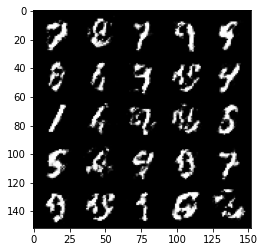

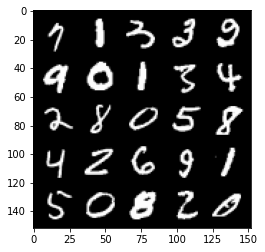


epoch 10: Generator loss: 13.006299844741816, discriminator loss: 4.2121776849627555


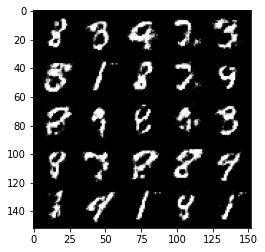

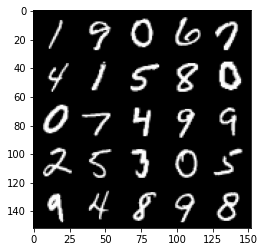


epoch 20: Generator loss: 12.175818988800005, discriminator loss: 4.401144436359416


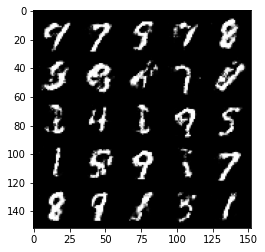

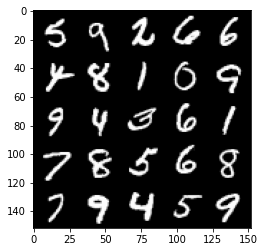


epoch 30: Generator loss: 11.4391933015585, discriminator loss: 4.666904869675614


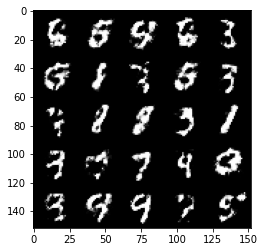

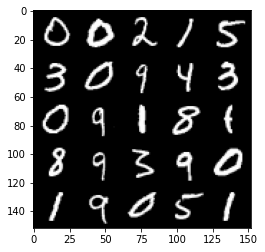


epoch 40: Generator loss: 11.319128238081944, discriminator loss: 4.656517188370221


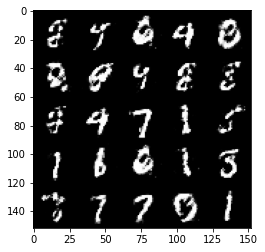

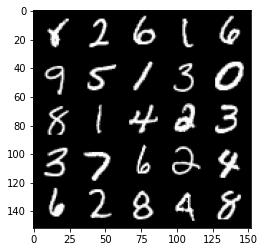


epoch 50: Generator loss: 10.750448603153233, discriminator loss: 4.8865974944829915


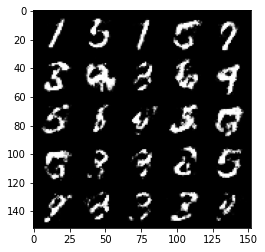

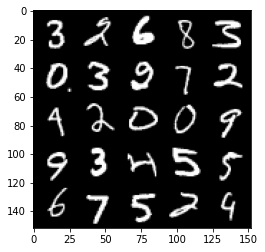


epoch 60: Generator loss: 10.069039567589757, discriminator loss: 5.044355272829529


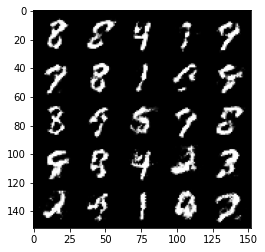

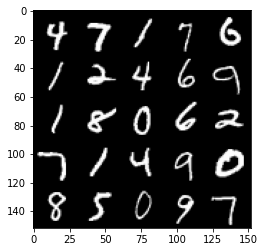


epoch 70: Generator loss: 10.16056492316726, discriminator loss: 5.04225475603341


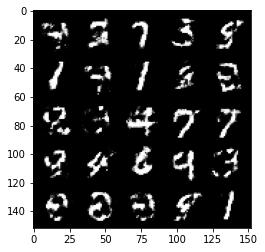

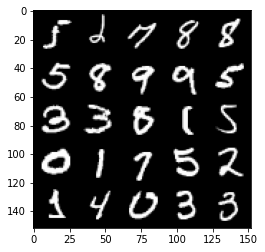


epoch 80: Generator loss: 9.762559877634077, discriminator loss: 5.161859572470192


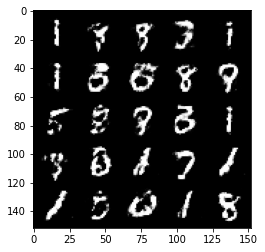

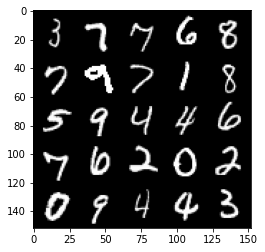


epoch 90: Generator loss: 9.523556933760633, discriminator loss: 5.206313164591794


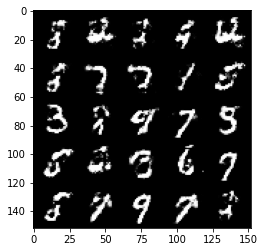

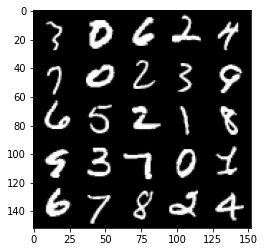

In [21]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False


for epoch in range(n_epochs): # 100 epochs
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        
        # Update discriminator
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # use only generator
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()
        
        # Update generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss ( gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
          try:
            assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
            assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
          except:
            error =True
            print("런타임 테스트 실패")

        mean_discriminator_loss += disc_loss.item() /display_step

        mean_generator_loss += gen_loss.item() / display_step
        
    # print per 10 epoch
    if epoch % 10 == 0:
      print(f"epoch {epoch}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      fake_noise = get_noise (cur_batch_size, z_dim, device =device)
      fake = gen(fake_noise)
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0